In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.7/site-packages/')
sys.path.append('..')

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy
from src.speech_segmentation import SpeechSegmentation
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

In [74]:
# Load segmentations from a specific trial
trial_number = "3ecf43e4-a4c8-11ec-bfc0-acde48001122"
ss = SpeechSegmentation()
ss.load(f"../data/study3/vocalic_series/coupled/{trial_number}")

In [75]:
def normalize_zero_mean(segment_series):
    values = []
    for segment in segment_series:
        values.extend(segment)
    mean = np.mean(values)
    std = np.std(values)
    
    return [[(x - mean) / std for x in segment] for segment in segment_series]    

def point_series_from_segment_series(segment_series):
    """
    This function computes the mean and standard error in each segment for all the segments in
    a time series of segments
    """
    
    means = [np.mean(seg) for seg in segment_series]
    errs = [np.std(seg)/np.sqrt(len(seg)) for seg in segment_series]
    
    return means, errs

<ErrorbarContainer object of 3 artists>

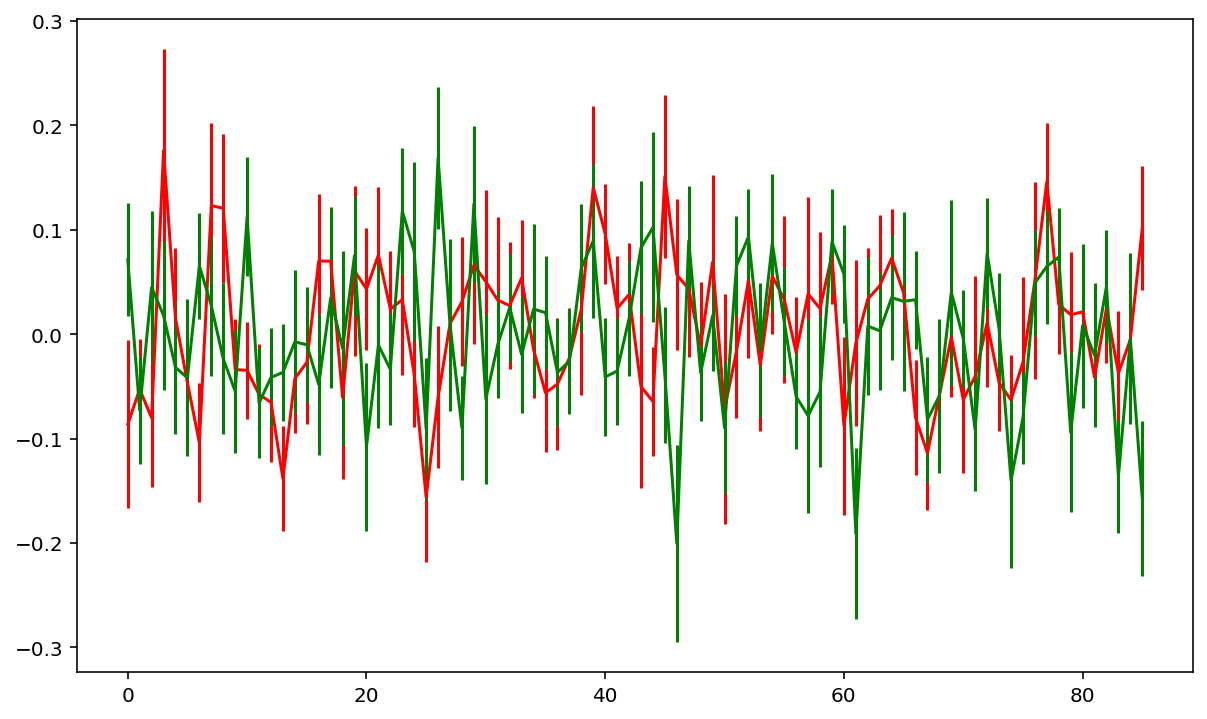

In [76]:
# Visualizing series for a specific dyad and vocalic feature
red_means, red_errs = point_series_from_segment_series(normalize_zero_mean(ss.red_to_green[0]["pitch"]))
green_means, green_errs = point_series_from_segment_series(normalize_zero_mean(ss.red_to_green[1]["pitch"]))
time_steps = np.arange(len(green_means))

plt.figure(figsize=(10, 6))
plt.errorbar(time_steps, red_means, yerr=red_errs, color="red")
plt.errorbar(time_steps, green_means, yerr=green_errs, color="green")

~~The plot above does not gives us much information. We are not interested in a point estimation but on the distribution of the vocalic features in each segmented utterance.~~

~~Below, we explore tranfer entropy to compute the mutual information between vocalic segments of a source and a target player. We do this for every segment, which represent the vocalic features within each player's conversational turn.~~

~~That plot will carry more information. It will tell us how mutual information changes over time for a specific dyad, which might uncover points of phase transition (high entropy) and/or loss of coordination.~~

Actually, conditioning the target segment on the source segment is not a good idea because we would be conditioning on a block. We are more interested in knowing whether a raise in pitch in the source utterance causes the same effect in the target utterance or the opposite. Therefore, we compute statistics over segments and estimate the transfer entropy over the series formed by those statistics.

In [106]:
def te_series_from_segment_series(source_segment_series, target_segment_series):
    """
    This function computes the mean and standard error of the tranfer entropy in each segment for all the segments in
    a time series of segments
    """
    
    mean_source_series = [np.mean(seg) for seg in source_segment_series]
    mean_target_series = [np.mean(seg) for seg in target_segment_series]
    
    # We use the R library to compute the transfer entropy
    r_transfer_entropy_pkg = importr("RTransferEntropy")
    r_transfer_entropy_function = r_transfer_entropy_pkg.calc_te    
    r_source_time_series = robjects.FloatVector(mean_source_series)     
    r_target_time_series = robjects.FloatVector(mean_target_series)
    return np.array(r_transfer_entropy_function(r_source_time_series, r_target_time_series))    

In [107]:
# Visualizing series of TE for a specific dyad and vocalic feature
te = te_series_from_segment_series(
    normalize_zero_mean(ss.red_to_green[0]["pitch"]), 
    normalize_zero_mean(ss.red_to_green[1]["pitch"]))
print(f"TE: {te}")

TE: [0.03742707]


In [ ]:
xs = np.random.randn(10)
ys = np.random.randn(10)
transfer_entropy(xs, ys, k=1, local=True)

In [21]:
# import os
# os.environ['R_HOME'] = "/Applications/R.app/Contents/MacOS/R"
r_transfer_entropy_pkg = importr("RTransferEntropy")
r_transfer_entropy_function = r_transfer_entropy_pkg.calc_te
r_y = robjects.FloatVector(np.random.randn(10))
r_age = robjects.FloatVector(np.random.randn(10))
r_dataframe = r_transfer_entropy_function(r_y, r_age)

In [23]:
r_dataframe

0.022978


0.022978,0.000000,0.000000,...,0.109223,0.000000,0.626667
